In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



In [15]:
datos_originales_conjunto_1 = pd.read_csv('Z_modificado.csv', index_col=0)
datos_originales_conjunto_1

,Date,Price
0,2010-01-01,2225.25
1,2010-01-04,2225.25
2,2010-01-05,2246.50
3,2010-01-06,2302.50
4,2010-01-07,2306.50
...,...,...
3560,2023-08-25,2123.50
3561,2023-08-28,2116.25
3562,2023-08-29,2116.25
3563,2023-08-30,2140.25


In [16]:
df = datos_originales_conjunto_1
# Convertir la columna 'fecha' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])




In [17]:
# las fechas están en desorden. Las ordenamos desde la "menor" fecha a la "mayor" (recordadndo que es DateTime)
df = df.sort_index()
# convertimos la columna 'Date' en el índice del DataFrame
df.set_index('Date', inplace=True)
df.dtypes

Price    float64
dtype: object

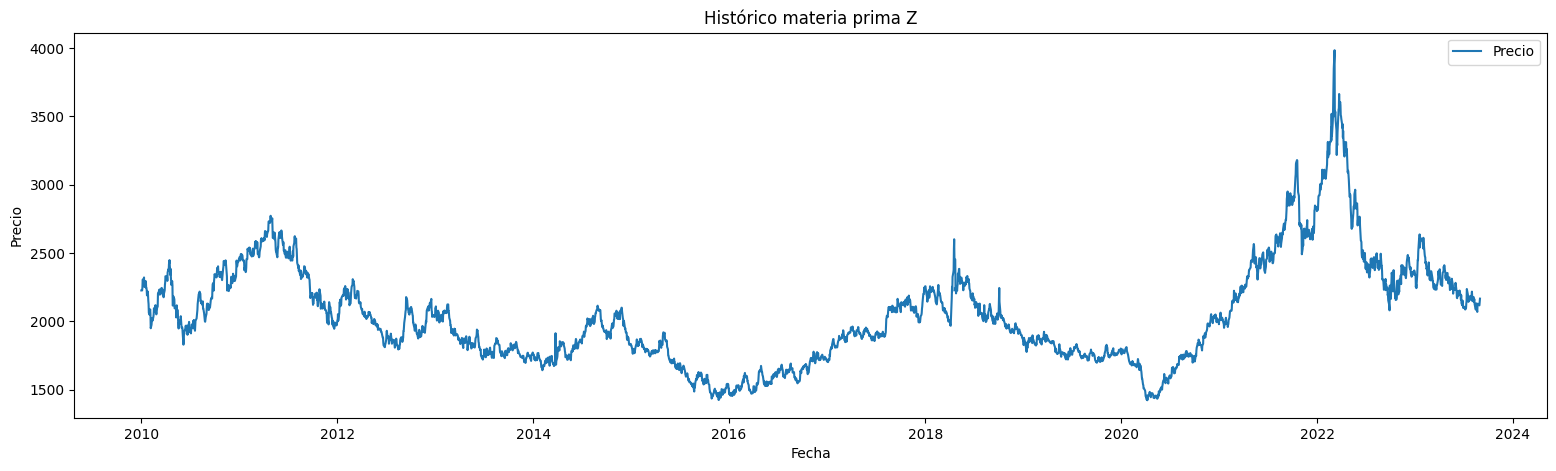

In [18]:
plt.figure(figsize=(19, 5))
plt.plot(df['Price'], label='Precio')
plt.title('Histórico materia prima Z')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

Error cuadrático medio (MSE): 4871.044997297578


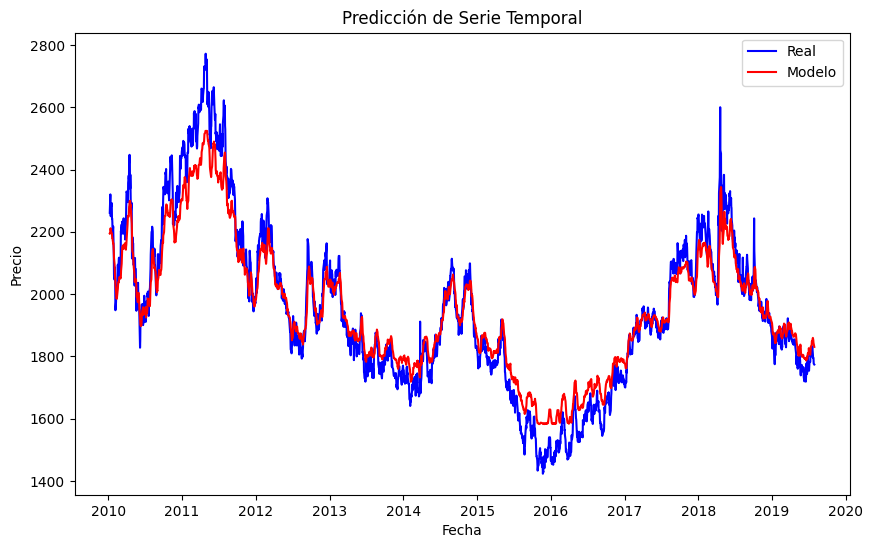

In [19]:
# Crear características de serie temporal (lag features)
def create_lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Price'].shift(lag)
    df = df.dropna()  # Eliminar filas con valores nulos
    return df

# Crear características de lag
df = create_lag_features(df, lags=5)

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Separar las características (X) y el target (y)
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1500, max_depth=4, learning_rate=0.001, colsample_bytree=0.3, reg_alpha=0.1, reg_lambda=0.1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Hacer predicciones
predictions = model.predict(X_train_scaled)

# Convertir las predicciones a un DataFrame
futuros = pd.DataFrame(predictions, index=train.index, columns=['Prediction'])


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_train, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(train.index, y_train, label='Real', color='blue')
plt.plot(train.index, predictions, label='Modelo', color='red')
plt.title('Predicción de Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



In [20]:
df

,Price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-08,2261.25,2306.50,2302.50,2246.50,2225.25,2225.25
2010-01-11,2320.25,2261.25,2306.50,2302.50,2246.50,2225.25
2010-01-12,2260.25,2320.25,2261.25,2306.50,2302.50,2246.50
2010-01-13,2250.25,2260.25,2320.25,2261.25,2306.50,2302.50
2010-01-14,2292.75,2250.25,2260.25,2320.25,2261.25,2306.50
...,...,...,...,...,...,...
2023-08-25,2123.50,2119.25,2128.75,2121.25,2068.25,2095.75
2023-08-28,2116.25,2123.50,2119.25,2128.75,2121.25,2068.25
2023-08-29,2116.25,2116.25,2123.50,2119.25,2128.75,2121.25


In [21]:
# Hacer que futuros cuente el index como una columna
futuros.reset_index(level=0, inplace=True)
futuros = futuros.rename(columns={'Prediction': 'Price'})
futuros

,Date,Price
0,2010-01-08,2194.662109
1,2010-01-11,2195.659424
2,2010-01-12,2211.516113
3,2010-01-13,2205.266846
4,2010-01-14,2197.808105
...,...,...
2487,2019-07-23,1856.890625
2488,2019-07-24,1852.509766
2489,2019-07-25,1844.069336
2490,2019-07-26,1840.486206


In [22]:

import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
import shap


In [25]:
# Create forecaster
# ==============================================================================
end_validation = '2023-12-09'

window_features = RollingFeatures(stats=["coef_variation"], window_sizes=2000)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 1000,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:end_validation, 'Price'])
forecaster

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  190  191  192  193  194  195  196
  197  198  199  200  201  202  203  204  205  206  207  208  209  210
  211  212  213  214  215  216  217  218  219  220  221  222  223  224
  225  226  227  228  229  230  231  232  233  234  235  236  237  238
  239  240  241  242  243  244  245  246  247  248  249  250  251  252
  253  254  255  256  257  258  259  260  261  262  263  264  265  266
  267  268  269  270  271  272  273  274  275  276  277  278  279  280
  281  282  283  284  285  286  287  288  289  290  291  292  293  294
  295  296  297  298  299  300  301  302  303  304  305  306  307  308
  309  310  311  312  313  314  315  316  317  318  319  320  321  322
  323  324  325  326  327  328  329  330  331  332  333  334  335  336
  337  338  339  340  341  342  343  344  345  346  347  348  349  350
  351  352  353  354  355  356  357  358  359  360  361  362  363  364
  365  366  367  368  369  370  371  372  373  374  375  376  377  378
  379  380  381  382  383  384  385  386  387  388  389  390  391  392
  393  394  395  396  397  398  399  400  401  402  403  404  405  406
  407  408  409  410  411  412  413  414  415  416  417  418  419  420
  421  422  423  424  425  426  427  428  429  430  431  432  433  434
  435  436  437  438  439  440  441  442  443  444  445  446  447  448
  449  450  451  452  453  454  455  456  457  458  459  460  461  462
  463  464  465  466  467  468  469  470  471  472  473  474  475  476
  477  478  479  480  481  482  483  484  485  486  487  488  489  490
  491  492  493  494  495  496  497  498  499  500  501  502  503  504
  505  506  507  508  509  510  511  512  513  514  515  516  517  518
  519  520  521  522  523  524  525  526  527  528  529  530  531  532
  533  534  535  536  537  538  539  540  541  542  543  544  545  546
  547  548  549  550  551  552  553  554  555  556  557  558  559  560
  561  562  563  564  565  566  567  568  569  570  571  572  573  574
  575  576  577  578  579  580  581  582  583  584  585  586  587  588
  589  590  591  592  593  594  595  596  597  598  599  600  601  602
  603  604  605  606  607  608  609  610  611  612  613  614  615  616
  617  618  619  620  621  622  623  624  625  626  627  628  629  630
  631  632  633  634  635  636  637  638  639  640  641  642  643  644
  645  646  647  648  649  650  651  652  653  654  655  656  657  658
  659  660  661  662  663  664  665  666  667  668  669  670  671  672
  673  674  675  676  677  678  679  680  681  682  683  684  685  686
  687  688  689  690  691  692  693  694  695  696  697  698  699  700
  701  702  703  704  705  706  707  708  709  710  711  712  713  714
  715  716  717  718  719  720  721  722  723  724  725  726  727  728
  729  730  731  732  733  734  735  736  737  738  739  740  741  742
  743  744  745  746  747  748  749  750  751  752  753  754  755  756
  757  758  759  760  761  762  763  764  765  766  767  768  769  770
 

In [26]:
final = forecaster.predict(steps=365)
final


c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


2000    2180.012695
2001    2176.470947
2002    2179.881104
2003    2179.451660
2004    2175.364746
           ...     
2360    1817.335571
2361    1825.343262
2362    1834.018677
2363    1834.143066
2364    1834.143066
Name: pred, Length: 365, dtype: float64

### predicción 2 años

In [27]:
'''
graficar SOLAMENTE las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Futuro de la materia prima X')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()
'''
final_2_anios = forecaster.predict(steps=730)
final_2_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


2000    2180.012695
2001    2176.470947
2002    2179.881104
2003    2179.451660
2004    2175.364746
           ...     
2725    2261.262695
2726    2235.239258
2727    2254.426758
2728    2234.571533
2729    2246.751709
Name: pred, Length: 730, dtype: float64

In [28]:
final_3_anios = forecaster.predict(steps=1095)
final_3_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


2000    2180.012695
2001    2176.470947
2002    2179.881104
2003    2179.451660
2004    2175.364746
           ...     
3090    2483.459717
3091    2483.459717
3092    2483.459717
3093    2483.459717
3094    2483.459717
Name: pred, Length: 1095, dtype: float64

---

---